# Preparando uma rede de segmentação (U-net)
* Ainda está um pouco nebuloso como funciona a U-net;
* Os conceitos de rede convolucionais também estão um pouco dificeis de fixar;
* Ainda preciso estudar melhor as redes convolucionais para entender a U-net;


## Passos para o desenvolvimento do nosso modelo
* 1º: Separar imagens e mascaras;
* 2º: Montar o nosso dataset; (São poucos dados, talvez fazer data augmentation)
* 3º: Separar dados em treino, validação e teste;
* 4º: Montar a rede U-Net;
* 5º: Treinar a rede;
* 6º: Verificar resultados;
* 7º: Verificar com dados de teste;
* 8º: Repetir passos do 5 ao 7 alterando hiperparâmetros;

### Modelo de Teste 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import preProcessing as preProcessing
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import os

folderSave = os.path.join("/mnt/d/ImagensDatasetFredrik/datasetToTrain", 'images/')
pathFiles = "/mnt/d/ImagensDatasetFredrik/masks/"
folderImgs = "/mnt/d/ImagensDatasetFredrik/datasetToTrain/imagesToProcess"

2023-04-27 16:25:14.705556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [58]:
# Verifica no csv todas as imagens que tem mascara
dfFileMasks = pd.read_csv("../CSVs/filesWithMask.csv")

In [59]:
# Mover todos as mascaras para a pasta maskExist
files = list(dfFileMasks['file_mask'])
os.mkdir(pathFiles+'masksExist')
for file in files:
    os.rename(pathFiles+file, pathFiles+'masksExist/'+file)

In [67]:
# As imagens ja estao no folder datasetToTrain
# Precisamos processar estas imagens e colocar no folder images
os.mkdir(folderSave) 
print(folderImgs)
print(folderSave)

/mnt/d/ImagensDatasetFredrik/datasetToTrain/imagesToProcess/
/mnt/d/ImagensDatasetFredrik/datasetToTrain/images


In [2]:
preProcessing.pre_Process_Images(pathImages=folderImgs, pathSave=folderSave)

Imagem para salvar: 00012_20990909_R_MLO_1.png
Imagem para salvar: 00045_20990909_L_CC_1.png
Imagem para salvar: 00075_20990909_L_CC_2.png
Imagem para salvar: 00075_20990909_L_MLO_2.png
Imagem para salvar: 00075_20990909_L_MLO_3.png
Imagem para salvar: 00142_20990909_R_CC_3.png
Imagem para salvar: 00142_20990909_R_MLO_1.png
Imagem para salvar: 00142_20990909_R_MLO_3.png
Imagem para salvar: 00155_20990909_L_CC_1.png
Imagem para salvar: 00157_20990909_R_CC_2.png
Imagem para salvar: 00157_20990909_R_CC_3.png
Imagem para salvar: 00157_20990909_R_MLO_2.png
Imagem para salvar: 00157_20990909_R_MLO_3.png
Imagem para salvar: 00181_20990909_L_CC_1.png
Imagem para salvar: 00181_20990909_L_MLO_1.png
Imagem para salvar: 00181_20990909_L_MLO_3.png
Imagem para salvar: 00189_20990909_L_CC_1.png
Imagem para salvar: 00189_20990909_L_MLO_1.png
Imagem para salvar: 00254_20990909_R_CC_1.png
Imagem para salvar: 00254_20990909_R_CC_2.png
Imagem para salvar: 00254_20990909_R_MLO_2.png
Imagem para salvar: 003

In [62]:
# Carregar imagens do HD
def load_data(path:str):
    images = glob(os.path.join(path, "images/*"))
    masks = glob(os.path.join(path, "masks/*"))
    return images, masks
images, masks = load_data('/mnt/d/ImagensDatasetFredrik/datasetToTrain')
print(len(images))
print(len(masks))

988
988


In [29]:
def resize(inputImage, inputMask):
    inputImage = tf.image.resize(inputImage, (128,128), method="nearest")
    inputMask = tf.image.resize(inputMask, (128,128), method="nearest")
    return inputImage, inputMask

def augment(inputImage, inputMask):
    inputImage = tf.image.flip_left_right(inputImage)
    inputMask = tf.image.flip_left_right(inputMask)
    return inputImage, inputMask

def normalize(inputImage, inputmask):
   inputImage = tf.cast(inputImage, tf.float32) / 255.0
   inputmask -= 1
   return inputImage, inputmask

def load_image_train(datapoint):
   inputImage = datapoint["image"]
   inputMask = datapoint["segmentation_mask"]
   inputImage, inputMask = resize(inputImage, inputMask)
   #inputImage, inputMask = augment(inputImage, inputMask)
   inputImage, inputMask = normalize(inputImage, inputMask)
   return inputImage, inputMask

def load_image_test(datapoint):
   inputImage = datapoint["image"]
   inputMask = datapoint["segmentation_mask"]
   inputImage, inputMask = resize(inputImage, inputMask)
   inputImage, inputMask = normalize(inputImage, inputMask)
   return inputImage, inputMask

In [30]:
trainDataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
testDataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [31]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = trainDataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = testDataset.take(3000).batch(BATCH_SIZE)
test_batches = testDataset.skip(3000).take(669).batch(BATCH_SIZE)

In [32]:
print(tf.data.experimental.cardinality(trainDataset).numpy())
print(tf.data.experimental.cardinality(testDataset).numpy())

3680
3669


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/home/lukasmachado/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-04-27 14:49:50.824696: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


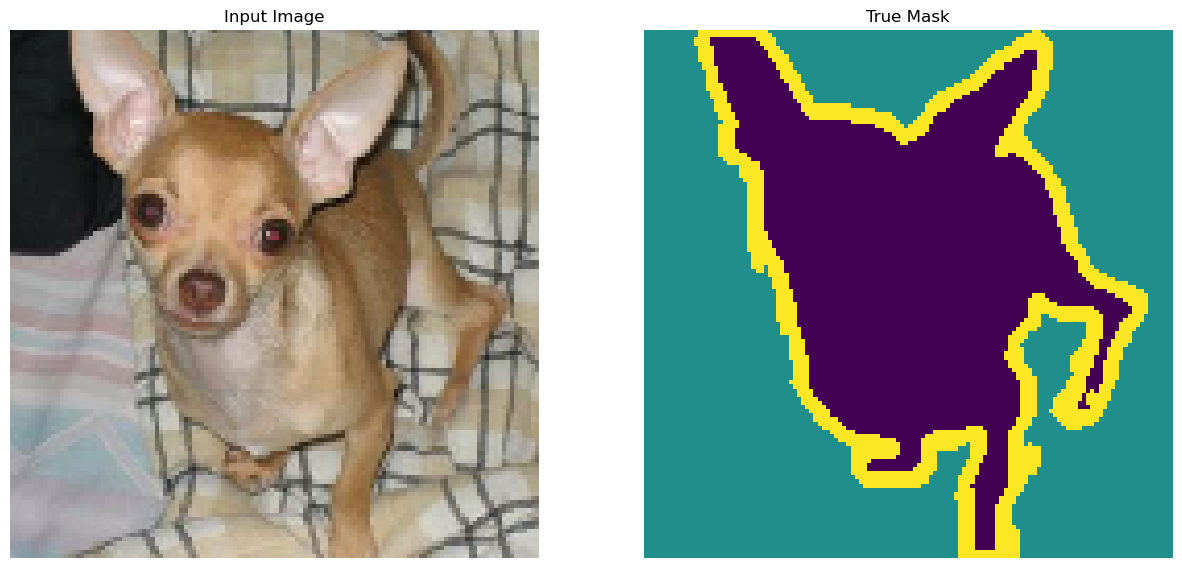

In [48]:
# verificar imagens e mascaras
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])